In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [3]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=train_transform),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=test_transform),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


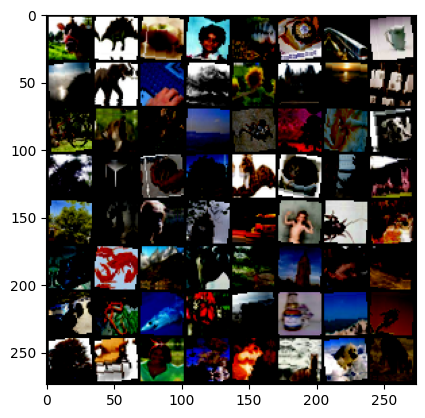

In [4]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

In [5]:
# Code inspired and adapted from PyTorch DCGAN tutorial https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# Code also inspired from this paper https://arxiv.org/abs/1511.06434
class Generator(nn.Module):
    def __init__(self, ngpu, nc=3, nz=80, ngf=48):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=48):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [6]:
# Code inspired and adapted from PyTorch DCGAN tutorial https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# Code also inspired from this paper https://arxiv.org/abs/1511.06434

# Parameters
ngpu = 1  # GPU
nz = 80  # Size of z latent vector
ngf = 48  # Size of feature maps in generator
ndf = 48  # Size of feature maps in discriminator
nc = 3    # Number of channels in the training images

# Create the generator and discriminator networks
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# Calculate the total number of trainable parameters in both networks
total_params_g = len(torch.nn.utils.parameters_to_vector(netG.parameters()))
total_params_d = len(torch.nn.utils.parameters_to_vector(netD.parameters()))

print(f'Total parameters in Generator: {total_params_g}')
print(f'Total parameters in Discriminator: {total_params_d}')

# Calculate the combined total parameters
combined_total_params = total_params_g + total_params_d
print(f'Combined total parameters in GAN: {combined_total_params}')

# Check if the total parameters exceed 1 million and print a warning if needed
if combined_total_params > 1000000:
    print("Warning: You have exceeded 1 million parameters and may incur a grade penalty.")

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the weights_init
netG.apply(weights_init)
netD.apply(weights_init)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Initialise BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Create batch of latent vectors that we will use to visualise the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

Total parameters in Generator: 617376
Total parameters in Discriminator: 374592
Combined total parameters in GAN: 991968


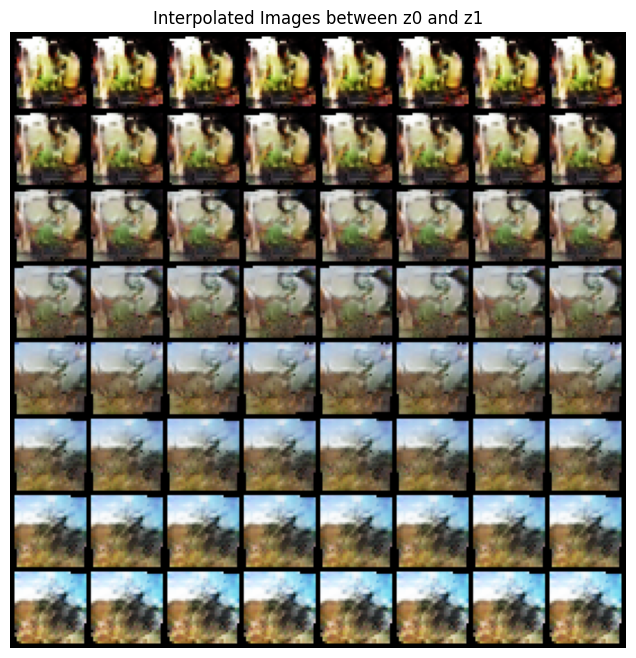

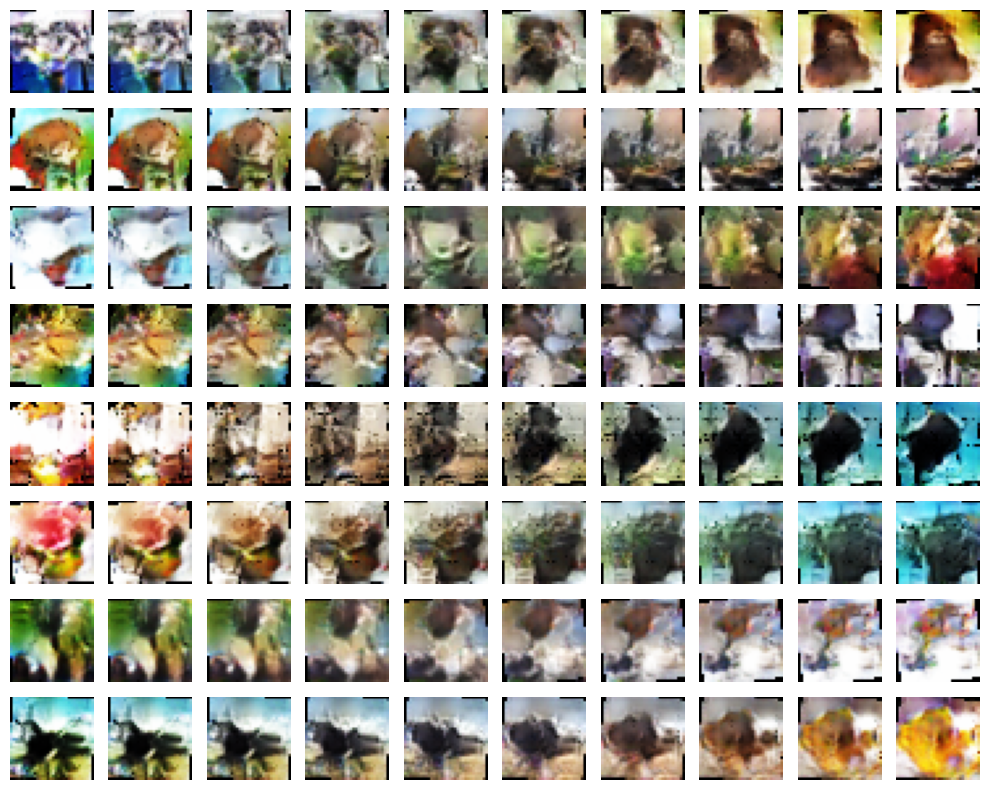

In [8]:
# Generate two points in the latent space
z0 = torch.randn(1, nz, 1, 1, device=device)
z1 = torch.randn(1, nz, 1, 1, device=device)

# Calculate the interpolation
col_size = int(np.sqrt(batch_size))
t = torch.linspace(0, 1, col_size).to(device)
t = t.view(-1, 1).repeat(1, col_size).view(-1, 1, 1, 1)
t = t.expand(batch_size, nz, 1, 1)

lerp_z = (1 - t) * z0 + t * z1  # Perform linear interpolation

with torch.no_grad():
   interpolated_images = netG(lerp_z)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Interpolated Images between z0 and z1")
plt.imshow(np.transpose(vutils.make_grid(interpolated_images, nrow=col_size, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

def interpolate_between_vectors(z1, z2, steps=10):
    # Generate interpolated vectors
    z = torch.zeros((steps, z1.size(1), 1, 1)).to(device)
    for i, alpha in enumerate(torch.linspace(0, 1, steps)):
        z[i] = (1. - alpha) * z1 + alpha * z2
    return z

# Set the total number of interpolation steps
interpolation_steps = 10

# Create figure for plotting
fig, ax = plt.subplots(8, interpolation_steps, figsize=(interpolation_steps, 8))

# Remove axis for all plots
for row in ax:
    for col in row:
        col.axis("off")

# Generate and plot interpolations
for i in range(8):
    # Generate two random points in the latent space
    z1 = torch.randn(1, nz, 1, 1, device=device)
    z2 = torch.randn(1, nz, 1, 1, device=device)
    
    # Interpolate between these two points
    z_interp = interpolate_between_vectors(z1, z2, interpolation_steps)
    
    # Generate images from the interpolated vectors
    with torch.no_grad():
        interpolated_images = netG(z_interp).cpu()

    # Plot the interpolated images in a row
    for j, img in enumerate(interpolated_images):
        ax[i][j].imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).numpy(),(1,2,0)))

plt.tight_layout()
plt.show()

In [9]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [10]:
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000  # Do not change


# create/clean the directories
def setup_directory(directory):
   if os.path.exists(directory):
       !rm -r {directory} # remove any existing (old) data
   os.makedirs(directory)


setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# Generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:
   z = torch.randn(64, nz, 1, 1, device=device)  # Generate random latent vectors
   with torch.no_grad():
       samples_batch = netG(z).detach().cpu()  # Generate a batch of images from the latent vectors
   for image in samples_batch:
       if num_generated >= num_samples:
           break
       save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
       num_generated += 1


# Save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
   real_samples_batch, _ = next(test_iterator)
   for image in real_samples_batch:
       if num_saved_real >= num_samples:
           break
       save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
       num_saved_real += 1

In [11]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")

compute FID between two folders


/home2/gtrd66/projectdeeplearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 10000 images in the folder real_images


FID real_images : 100%|██████████| 313/313 [01:25<00:00,  3.68it/s]


Found 10000 images in the folder generated_images


FID generated_images : 100%|██████████| 313/313 [01:27<00:00,  3.59it/s]


FID score: 53.36792214935514
